This is a notebook to learn/practice survival analysis. I am following this tutorial in R: https://www.emilyzabor.com/survival-analysis-in-r.html and adapting it to python, with the help of thess tutorials: https://medium.com/the-researchers-guide/survival-analysis-in-python-km-estimate-cox-ph-and-aft-model-5533843c5d5d and https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html


The purpose is to learn about survival analysis, but also practice python.

Survival analysis: 

What is the probability of an event (δ) happening (yes=1, no=0) at a certain time (t)?

Y = Surv(t, δ)

But there is an important additional consideration, which is censoring/ censored events - when we cannot know when/if the event happened (e.g. patient dropped out, event didn't occur before the end of the study). We can only tell that these patients were event-free up to their last follow-up.

T = time of event
C = time of censoring

For patient i, Yi = min (Ti, Ci) , e.g. time of event or time of censoring, would be T if event occurs (δ = 1) and C if event doesn't occur (δ = 0).






General reproducibility workflow (do these on the terminal)

1.Created a virtual environment:

    python -m venv .venv

1.1. Activate using: 
    
    source .venv/bin/activate

1.2. Can check which venv is active by writing on terminal:

    which python

1.3. Make sure you deactivate anything e.g. conda: 

    conda deactivate
    
Some guidance: https://packaging.python.org/en/latest/guides/installing-using-pip-and-virtual-environments/

2.Installing packages:

    python3 -m pip install package_name

    python3 -m pip freeze > requirements.txt       #to save information on packages install in this file


3.Create git repo using VS code interface or terminal: 
    
    git init

4.Make sure kernel is the .venv in use in jupyter notebook


In [2]:
#load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lifelines import KaplanMeierFitter


Data download. I downloaded it from the R library 'survival' and saved it in this folder. 

In [3]:
lung = pd.read_csv('lung.csv', index_col=0)
lung.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


In [4]:
print(lung.info())
print(lung.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, 1 to 228
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       227 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    227 non-null    float64
 6   ph.karno   227 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 19.6 KB
None
             inst         time      status         age         sex  \
count  227.000000   228.000000  228.000000  228.000000  228.000000   
mean    11.088106   305.232456    1.723684   62.447368    1.394737   
std      8.303491   210.645543    0.448159    9.073457    0.489870   
min      1.000000     5.000000    1.000000   39.000000    1.000000   
25%      3.000

In [5]:
# change status and sex from 1,2 to 0,1 
lung.replace({'status': {1: 0, 2: 1}}, inplace=True)
lung.replace({'sex': {1: 0, 2: 1}}, inplace=True)
lung.head()

#look at only specific variables
print(lung[['time', 'status', 'sex']].head())


   time  status  sex
1   306       1    0
2   455       1    0
3  1010       0    0
4   210       1    0
5   883       1    0


In [6]:
#Count N/As
print(lung.isnull().sum())
print(lung.shape)

# Remove NAs: average continuous data (meal.cal and wt.loss), and drop the others (not many so won't reduce the dataset as much)
lung['meal.cal'].replace(np.nan, lung['meal.cal'].mean(), inplace=True) 
lung['wt.loss'].replace(np.nan, lung['wt.loss'].mean(), inplace=True) 
lung.dropna(axis=0, inplace=True) #drop everything else

print(lung.isnull().sum())
print(lung.shape)

lung.info()
lung.head()

inst          1
time          0
status        0
age           0
sex           0
ph.ecog       1
ph.karno      1
pat.karno     3
meal.cal     47
wt.loss      14
dtype: int64
(228, 10)
inst         0
time         0
status       0
age          0
sex          0
ph.ecog      0
ph.karno     0
pat.karno    0
meal.cal     0
wt.loss      0
dtype: int64
(222, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, 1 to 228
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       222 non-null    float64
 1   time       222 non-null    int64  
 2   status     222 non-null    int64  
 3   age        222 non-null    int64  
 4   sex        222 non-null    int64  
 5   ph.ecog    222 non-null    float64
 6   ph.karno   222 non-null    float64
 7   pat.karno  222 non-null    float64
 8   meal.cal   222 non-null    float64
 9   wt.loss    222 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 19.1 KB


/var/folders/yp/zg1mrvn13v1cskv5dd2rq8kw0000gn/T/ipykernel_68042/788081705.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lung['meal.cal'].replace(np.nan, lung['meal.cal'].mean(), inplace=True)
/var/folders/yp/zg1mrvn13v1cskv5dd2rq8kw0000gn/T/ipykernel_68042/788081705.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
1,3.0,306,1,74,0,1.0,90.0,100.0,1175.000000,9.831776
2,3.0,455,1,68,0,0.0,90.0,90.0,1225.000000,15.000000
3,3.0,1010,0,56,0,0.0,90.0,90.0,928.779006,15.000000
4,5.0,210,1,57,0,1.0,90.0,60.0,1150.000000,11.000000
5,1.0,883,1,60,0,0.0,100.0,90.0,928.779006,0.000000


In [7]:
lung.sort_values('time', inplace=True)
lung.head(10)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
57,5.0,5,1,65,1,0.0,100.0,80.0,338.000000,5.000000
73,5.0,11,1,74,0,2.0,70.0,100.0,1175.000000,0.000000
108,1.0,11,1,67,0,1.0,90.0,90.0,925.000000,9.831776
30,1.0,12,1,74,0,2.0,70.0,50.0,305.000000,20.000000
215,11.0,13,1,65,0,1.0,80.0,90.0,928.779006,10.000000
116,1.0,13,1,76,0,2.0,70.0,70.0,413.000000,20.000000
111,13.0,15,1,69,0,0.0,90.0,70.0,575.000000,10.000000
32,1.0,26,1,73,0,2.0,60.0,70.0,388.000000,20.000000
96,12.0,30,1,72,0,2.0,80.0,60.0,288.000000,7.000000
149,12.0,31,1,82,0,0.0,100.0,90.0,413.000000,27.000000


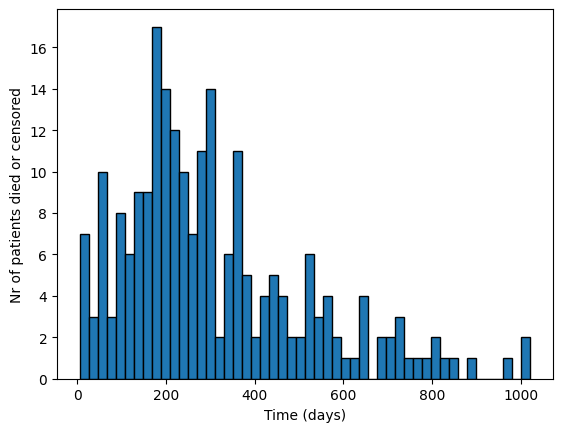

In [8]:
# Look at the distribution of the time variable
T = lung['time']
E = lung['status']

plt.hist(T, bins=50, edgecolor='black')
plt.xlabel('Time (days)')
plt.ylabel('Nr of patients died or censored')
plt.show()

Kaplan Meyer Estimator takes into account right-censoring, so it is the best for survival curves. Two packages, lifelines - more simple, easy to use, sksurvival - part of scikit-learn and can be integrated with more advanced ML from it. I will start with lifelines. 

Text(0.5, 0, 'Survival Time (days)')

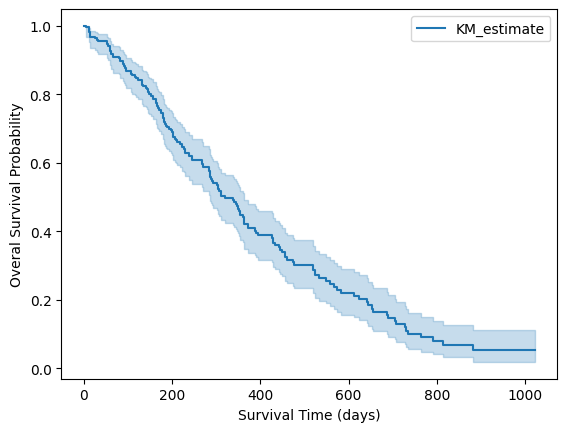

In [17]:
#Initiate object
kmf = KaplanMeierFitter()
#Fit the object
kmf.fit(durations = T, event_observed = E)
#Plot with 95%CI - check coursera MedicineAI for info on confidence intervals
kmf.plot_survival_function()
plt.ylabel('Overal Survival Probability')
plt.xlabel('Survival Time (days)')

In [ ]:
# Calculate median survival time (not normally distributed so not good to look at mean)
from lifelines.utils import median_survival_times
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("Median survival time:", median_)
print("Confidence intervals:", median_confidence_interval_)

Median survival time: 320.0
Confidence intervals:      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   285.0                   363.0


In [ ]:
# Probability of surviving to 1 and 2 years

timeline = [365, 730] # 1 year and 2 years

times = kmf.survival_function_at_times(timeline)

#make it a nice dataframe
times = pd.DataFrame(times).reset_index()
times.rename(columns={"index":"days"}, inplace=True)
times['KM_estimate'] = times['KM_estimate'].apply(lambda x: round(x, 2))

times



   days  KM_estimate
0   365         0.42
1   730         0.12


Text(0.5, 1.0, 'Survival of different gender group')

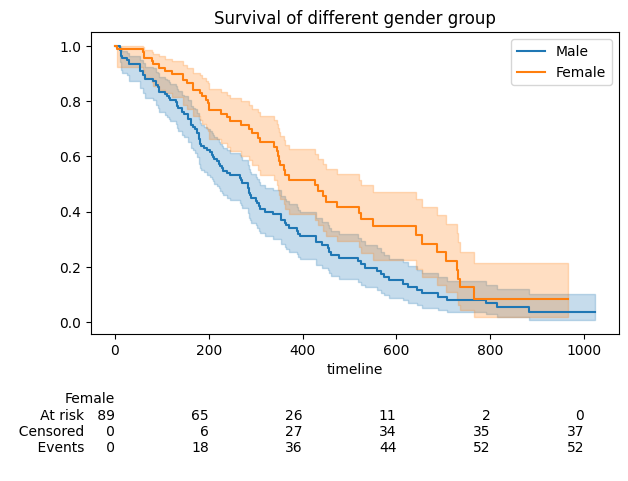

In [ ]:
# Look at differences between categorical groups (SEX)
#create axis object
ax = plt.subplot(111)
#create a filter for Male (male = 0, female = 1)
m = (lung['sex'] == 0)
#Fit the object and plot (filtered to male)
kmf.fit(durations = T[m], event_observed = E[m], label = "Male")
kmf.plot_survival_function(ax = ax)
#Fit the object and plot (filtered to NOT male)
kmf.fit(T[~m], event_observed = E[~m], label = "Female")
kmf.plot_survival_function(ax = ax)
plt.title("Survival of different gender group")


ph.ecog (i3): ECOG performance score as rated by the physician. 0 = asymptomatic, 1 = symptomatic but completely ambulatory, 2 = in bed <50% of the day, 3 = in bed > 50% of the day but not bed bound, 4 = bed bound

In [35]:
ecog_types = np.sort(lung['ph.ecog'].unique())
print(ecog_types)

[0. 1. 2. 3.]


ph.ecog
1.0    113
0.0     62
2.0     46
3.0      1
Name: count, dtype: int64
[0. 1. 2. 3.]


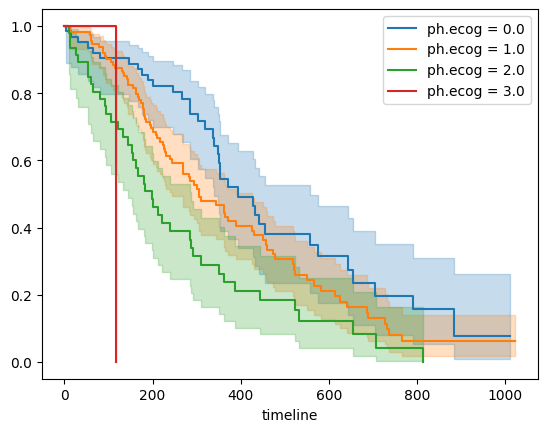

In [ ]:
# Look at differences between categorical groups (ph.ecog)
# look at different categories
print(lung['ph.ecog'].value_counts())

ecog_types = np.sort(lung['ph.ecog'].unique())
print(ecog_types)

#all in one plot
for x in ecog_types:
    m = (lung['ph.ecog'] == x)
    ax = plt.subplot(111)
    kmf.fit(durations = T[m], event_observed = E[m], label = 'ph.ecog = ' + str(x))
    kmf.plot_survival_function(ax = ax)






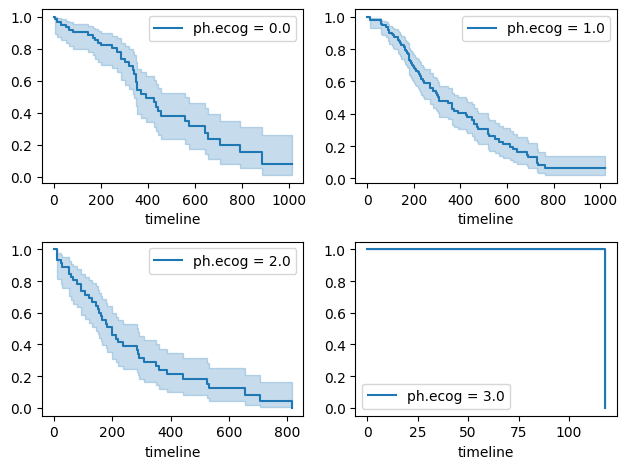

In [46]:
#4 plots     
for i, x in enumerate(ecog_types):
    m = (lung['ph.ecog'] == x)
    ax = plt.subplot(2,2, i+1)
    kmf.fit(durations = T[m], event_observed = E[m], label = 'ph.ecog = ' + str(x))
    kmf.plot_survival_function(ax = ax)
plt.tight_layout()


Cox Proportional Hazard Model
* Used when we have many variables (co-variates) that can influence survival
* semi-parametric
* has assumptions that need checking!
* Hazard rate: probability of event happening (death)
* Coefficient tells the influence of co-variates on the hazard rate; hazard ratio is the coefficient exponentiated (easier to interpret) - HR > 1 increased   , HR < 1 decreased risk of event


Step 1: Data preparation

* Categorical data must be converted to numerical (e.g. if sex was male and female, would need to be converted to 0 and 1)
* Need to dummy code categorical variables (because want only 0 or 1)

In [ ]:
print(lung['ph.ecog'].value_counts())
#drop ecog_3.0 because it only has 1 true value
lung = lung[lung['ph.ecog'] != 3.0]
print(lung['ph.ecog'].value_counts())

#create dummies
dummies_ecog = pd.get_dummies(lung['ph.ecog'], prefix = 'ecog', dtype=float)
dummies_ecog = dummies_ecog[["ecog_1.0", "ecog_2.0"]] #need to drop one column to avoid multi-collinearity?? the dropped column will be the base

print(dummies_ecog.head())

#merge datasets
lung_cox = lung.drop('ph.ecog', axis=1) #drop the original ecog
lung_cox.info()

lung_cox = pd.concat([lung_cox, dummies_ecog], axis=1)
print(lung_cox.head())

#just checking the the row index are equal so that the concatenation is correct
print(lung_cox.index.equals(dummies_ecog.index))  # should be True


ph.ecog
1.0    113
0.0     62
2.0     46
Name: count, dtype: int64
ph.ecog
1.0    113
0.0     62
2.0     46
Name: count, dtype: int64
     ecog_1.0  ecog_2.0
57        0.0       0.0
73        0.0       1.0
108       1.0       0.0
30        0.0       1.0
215       1.0       0.0
<class 'pandas.core.frame.DataFrame'>
Index: 221 entries, 57 to 6
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       221 non-null    float64
 1   time       221 non-null    int64  
 2   status     221 non-null    int64  
 3   age        221 non-null    int64  
 4   sex        221 non-null    int64  
 5   ph.karno   221 non-null    float64
 6   pat.karno  221 non-null    float64
 7   meal.cal   221 non-null    float64
 8   wt.loss    221 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 25.4 KB
     inst  time  status  age  sex  ph.karno  pat.karno     meal.cal  \
57    5.0     5       1   65    1     100.0       80.0   338.0

In [70]:
# Fitting the COX-PH Model (from lifelines package)
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(lung_cox, duration_col = 'time', event_col = 'status')
cph.print_summary()

AttributeError: The '.style' accessor requires jinja2

<lifelines.CoxPHFitter: fitted with 221 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 221
number of events observed = 158
   partial log-likelihood = -692.69
         time fit was run = 2025-08-13 11:30:27 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
inst      -0.02      0.98      0.01           -0.05           -0.00                0.95                1.00
age        0.01      1.01      0.01           -0.01            0.03                0.99                1.03
sex       -0.57      0.57      0.17           -0.91           -0.23                0.40                0.80
ph.karno   0.02      1.02      0.01           -0.00            0.04                1.00                1.04
pat.karno -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
meal.cal   0.00      1.00      0.00           -0.00            0.00                1.00                1.00
wt.loss   -0.01      0.99      0.01           -0.03           -0.00                0.97                1.00
ecog_1.0   0.76      2.14      0.25            0.27            1.25                1.31                3.47
ecog_2.0   1.41      4.09      0.40            0.63            2.19                1.87                8.97

           cmp to     z      p  -log2(p)
covariate                               
inst         0.00 -2.19   0.03      5.12
age          0.00  1.32   0.19      2.43
sex          0.00 -3.28 <0.005      9.91
ph.karno     0.00  1.85   0.06      3.97
pat.karno    0.00 -1.76   0.08      3.67
meal.cal     0.00  0.05   0.96      0.05
wt.loss      0.00 -1.98   0.05      4.39
ecog_1.0     0.00  3.06 <0.005      8.81
ecog_2.0     0.00  3.52 <0.005     11.20
---
Concordance = 0.65
Partial AIC = 1403.38
log-likelihood ratio test = 39.52 on 9 df
-log2(p) of ll-ratio test = 16.72

<Axes: xlabel='log(HR) (95% CI)'>

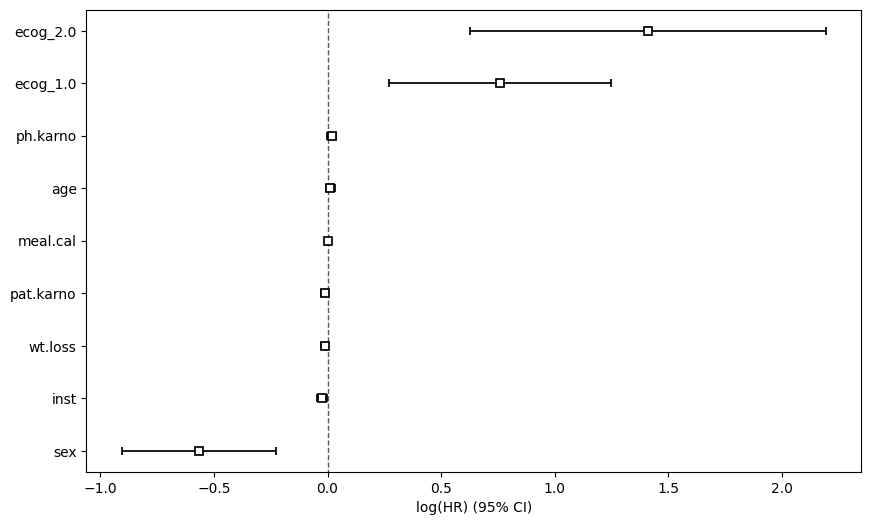

In [71]:
plt.subplots(figsize = (10, 6))
cph.plot()
